# Projet Python pour la data science 

Auteurs : NGUEMOGNE Sandra, Rougier Antoine

L'objectif de ce notebook est de présenter le projet que nous avons effectué dans le cadre de l'unité d'enseignement Python pour la data science dispensée à l'ENSAE. Ce projet a été élaboré de manière libre et comporte, comme attendu, un jeu de données récupéré et traité, une partie visualisation et une partie modélisation.

# Problématique 

Ce projet s'articule autour de la problématique suivante : Comment peut-on créer une modélisation pertinente des prix que nous cherchons, et comment peut-on comparer cela avec une véritable stratégie financière ? (le modèle Black-Sholes)

La structure est divisée en deux parties distinctes :
- dans un premier temps, nous allons récupérer le jeu de donnée, et basé notre modèle dessus 
- puis nous utiliserons la méthode Black-Sholes pour comparer les deux méthodes 

# Installations préalables 

Avant d'exécuter veuillez procéder aux installations de modules nécessaires au bon fonctionnement du code en exécutant la cellule ci-dessous.

In [1]:
!pip install yfinance
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 368.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 20.6 MB/s eta 0:00:0000:0100:01


# Importation des modules 

In [65]:
import yfinance as yahooFinance
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_X_y
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Récupération et traitement des données 

La première étape de notre projet a été la récupération et le traitement des données. Dans notre cas, nous avons fait le choix de récupérer des données fournis directement sur le site Yahoo Finance.

In [90]:
start_Date = datetime.datetime(2019, 1, 1)
end_Date = datetime.datetime(2019, 12, 31)

GetAXAInfo = yahooFinance.Ticker("CS.PA")
df_init=GetAXAInfo.history(start=start_Date,end=end_Date)

# Traitement des données 

Nous voulons d'abord savoir le nombre de ligne que comporte ce tableau, puis nous voulons connaître les informations qui se trouvent dans chaque colonnes. 

In [4]:
print(len(df_init))
print(df_init.columns)

255
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [47]:
print(df_init.head())

                                Open       High        Low      Close  \
Date                                                                    
2019-01-02 00:00:00+01:00  13.595196  13.738302  13.455008  13.731001   
2019-01-03 00:00:00+01:00  13.599576  13.836142  13.589354  13.617100   
2019-01-04 00:00:00+01:00  13.720779  14.087309  13.666749  14.044961   
2019-01-07 00:00:00+01:00  14.078548  14.150101  13.900394  13.982169   
2019-01-08 00:00:00+01:00  14.027436  14.218733  13.988009  14.034738   

                             Volume  Dividends  Stock Splits  
Date                                                          
2019-01-02 00:00:00+01:00   8028529        0.0           0.0  
2019-01-03 00:00:00+01:00   6583413        0.0           0.0  
2019-01-04 00:00:00+01:00  11675578        0.0           0.0  
2019-01-07 00:00:00+01:00   7530045        0.0           0.0  
2019-01-08 00:00:00+01:00   7314687        0.0           0.0  


On va regarder maintenant des informations spécifiques sur les colonnes en utilisant la fonction describe

In [53]:
df_init.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,255.000000,255.000000,255.000000,255.000000,2.550000e+02,255.000000,255.0
mean,17.233804,17.364001,17.126566,17.259327,6.180807e+06,0.005255,0.0
std,1.427426,1.419908,1.425413,1.425055,2.229986e+06,0.083914,0.0
min,13.595197,13.738303,13.455009,13.617098,0.000000e+00,0.000000,0.0
25%,16.391627,16.570513,16.289409,16.439543,4.741434e+06,0.000000,0.0
50%,17.344898,17.443028,17.182398,17.333290,5.805304e+06,0.000000,0.0
75%,18.283140,18.428228,18.182544,18.312158,7.141672e+06,0.000000,0.0
max,19.646974,19.685665,19.546381,19.658583,1.826625e+07,1.340000,0.0


A première vue, il ne semble pas y avoir de valeur aberrante dans notre dataframe. Ce dataframe semble complet pour les informations que nous voulons utiliser. 

Il est difficile d'identifier des valeurs aberrantes dans la colonne Volume, car cela dépend énormément des transcations des différents acteurs financiers (rachat d'une partie de l'entreprise ce qui donnera une valeur élévée, mauvais résultat d'Axa ventent d'actions mais sans personnes qui ne voudraient racheter. 

Pour le reste des colonnes, on se rend compte que la colonnes Stock Splits est vide, ainsi il faudra la supprimer pour le reste du projet. 

Pour les colonnes qui indiques les prix de l'action jour par jour, à première vu, nous ne détectons pas de valeurs aberrantes notamment en regardant les moyennes, les prix maximaux et minimaux du cours des actions. 

Nous allons donc conserver ce jeu de donnée et le modifier un peu pour simplifier notre travail dans la suite du projet. 

Nous remarquons que les dates peuvent poser un problème dans notre modélisation, car elles sont converties sous le format Unix, et que les heures ne nous intérèssent pas particulière dans notre projet. 
Ainsi nous allons d'abord convertir ces dates dans un format qui ne nous posera pas de problème pour se faire nous mettons les dates dans une nouvelle colonne car elles sont utilisés ici comme indexes puis nous effectons le changement que nous voulons avant de les remettre comme indexes.  

In [91]:
df_init = df_init.reset_index()
df_init["Date"] = df_init["Date"].dt.strftime('%Y-%m-%d')
df_init = df_init.set_index('Date')
df_init.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,13.595194,13.738301,13.455006,13.730999,8028529,0.0,0.0
2019-01-03,13.599575,13.836141,13.589353,13.617099,6583413,0.0,0.0
2019-01-04,13.720780,14.087310,13.666750,14.044962,11675578,0.0,0.0
2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,0.0
2019-01-08,14.027438,14.218735,13.988011,14.034739,7314687,0.0,0.0


Nous décidons donc de supprimer les colonnes que nous jugeons inutiles dans notre modèle, et même si la colone dividends n'est pas toujours nulle, elle ne nous servira pas pour le reste du projet. Ainsi, on utilise la fonction drop pour enlever ces colones en questions.

In [92]:
df_init = df_init.drop(columns =  ["Low", "High", "Dividends","Stock Splits"])
df_init.head()

,Open,Close,Volume
Date,,,
2019-01-02,13.595194,13.730999,8028529
2019-01-03,13.599575,13.617099,6583413
2019-01-04,13.720780,14.044962,11675578
2019-01-07,14.078546,13.982167,7530045
2019-01-08,14.027438,14.034739,7314687


Pour conclure sur cette première partie, nous avons importé des données qui étaient déjà traité, ce qui nous a facilité la tâche dans cette partie, puis nous avons du effectuer quelques modifications sur la base de donnée sinon cela faussait notre modélisation, puis nous avons enlever les colonnes que nous jugions inutiles pour le reste de notre projet. 

# Visualisation des données 

Dans cette partie, nous vonlous afficher un graphique des prix de l'action Axa au cours de l'année 2019, puis de faire un histogramme de la somme de chaque volume échanger par mois pour voir s'il y a des périodes d'échange significative. 

Pour commencer nous décidons de faire une copie de notre base de donnée. 

In [93]:
df2 = df_init.copy()

Ensuite, nous allons donc afficher un graphique des prix d'ouverture de l'action Axa sur cette période. 

Text(0.5, 0, 'Temps')

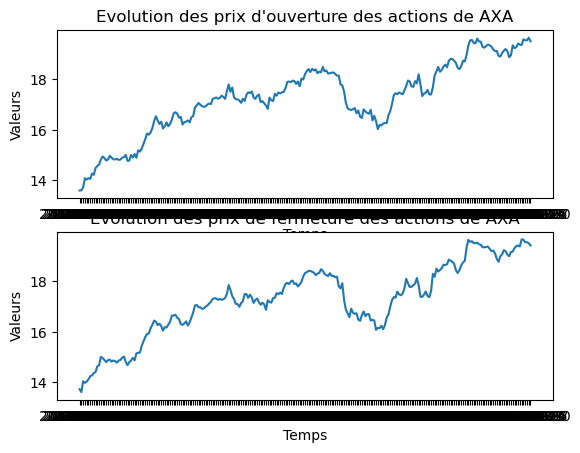

In [94]:
new_df = df2[['Open']]
new_df2 = df2[['Close']]
plt.subplot(211)
plt.plot(new_df)
plt.title("Evolution des prix d'ouverture des actions de AXA")
plt.ylabel("Valeurs")
plt.xlabel("Temps")

plt.subplot(212)
plt.plot(new_df2)
plt.title("Evolution des prix de fermeture des actions de AXA")
plt.ylabel("Valeurs")
plt.xlabel("Temps")

Nous voyons ici que les prix croissent à un certains rythme et que qu'il n'y a pas d'erreur dans nos données pour les prix d'ouverture. Nous n'avons pas de valeur abérante qui fausserait le graphique. Nous en concluons alors que nous pouvons utiliser cette base de donnée pour faire notre modèle.

On veut aussi avoir un histogramme qui nous montre le nombre de transaction par mois de l'action AXA pour voir si il y a une évolution au cours de l'année 2019.
Pour ce faire nous allons utiliser la méthode groupby de pandas pour créer des nouveaux tableaux qui correspondent à chaque mois de l'année. Nous allons donc changer les dates pour ne conserver uniquement le mois. Afin, nous devons aussi réorgarniser les indexes, car sinon nous auriont un groupby dans l'ordre alphabétique, ce qui peut fausser notre interprétation. Et nous sommons toutes les valeurs de chaque mois pour avoir un nombre de transaction effectuer ce qui correspond donc aux volumes échangers chaque mois.

Une fois cela fait, nous affichons un histograme dans l'ordre chronologique et un camembert pour regarder si certains mois de l'année sont plus susceptible d'avoir plus ou moins de transaction. Comme nous savons que certaines périodes peuvent être plus creuse que d'autres comme pour la période allant de Juin à Août. 

Enfin, nous aimerions savoir s'il y a une corréalation entre les prix de fermeture et les volumes échangers. 

/tmp/ipykernel_165/4027404993.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df_grouped.sum().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])


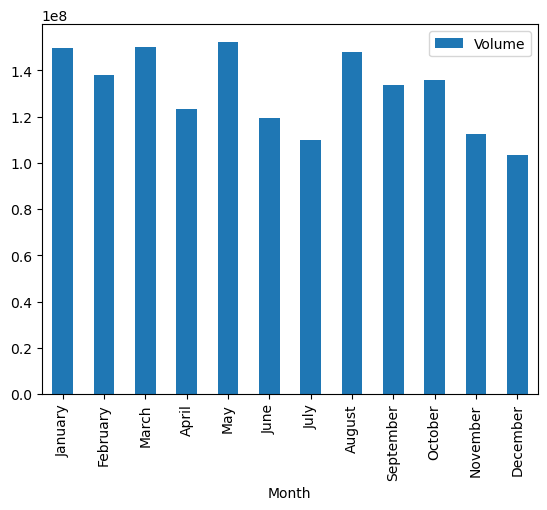

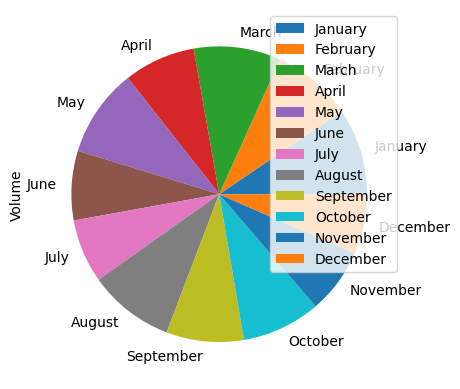

,Open,Volume
Open,1.00000,-0.24745
Volume,-0.24745,1.00000


In [95]:
new_df = df2[['Volume']]
new_df
new_df = new_df.reset_index()
new_df['Month'] = pd.to_datetime(new_df['Date']).dt.strftime('%B')
df_grouped = new_df.groupby(new_df['Month'])


#for key, item in df_grouped:
#    print(key)
#    print(df_grouped.get_group(key))


sums = df_grouped.sum().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
sums
sums.plot.bar()
plt.show()

sums.plot.pie(subplots=True)
plt.show()

df2 = df2.drop(columns =  ["Close"])
df2.corr()


On remarque alors que les volommes échanger pendant cette année 2019 reste relativement similaire pour chaque mois, nous ne voyons pas d'écart significatif au cours de cette période. De plus, nous voyons aussi une corrélation négative entre le prix d'ouverture et les volumes échangers. Nous pouvions nous attendre à ce résultat en pensant à la loi de l'offre et de la demande pour fixer un prix. Donc pour l'instant nous ne voyons pas de grosse anomalie sur nos données. 

# III Modélisation d'un modèle de régression linéaire pour prédire les prix de fermeture de l'action

Dans cette partie, notre objectif est de faire une prédiction, grâce au prix d'ouverture du matin avec les prix de fermeture de la veille pour prédire le prix de fermeture du soir. 

Ainsi, nous construisons une nouvelle colonnes qui s'appelle Close_veille et a qui on associe le prix de fermeture de la veille. 

In [96]:
dec=df_init["Close"].shift(1)
df_init= df_init.assign(Close_veille=dec)
df_init.head()

,Open,Close,Volume,Close_veille
Date,,,,
2019-01-02,13.595194,13.730999,8028529,NaN
2019-01-03,13.599575,13.617099,6583413,13.730999
2019-01-04,13.720780,14.044962,11675578,13.617099
2019-01-07,14.078546,13.982167,7530045,14.044962
2019-01-08,14.027438,14.034739,7314687,13.982167


Nous allons maintenant faire une régression multilinéaire en utilisant le prix d'ouverture et le prix de fermeture de la veille pour prédire le prix de fermeture de la journée. 

On crée une colonne X qui comporte les variables explicatives, et une colonne Y qui prend les prix de fermeture. 
Pour la colonne X, on enlève la première ligne, car il n'y avait pas de prix de la veille. 

On décide de faire d'entraîner le modèle sur environ 2/3 des données puis de tester le modèle sur le 1/3 restant. 

Enfin on s'inspire de scikit-learn pour faire notre régression multilinéaire, et on affiche en vert nos Y prédit par le modèle et en gris les prix réels de fermeture. 
Nous affichons aussi les coefficients de cette régression et l'erreur au carré. 

[[0.85780377 0.12703196]]
Mean squared error: 0.03
Coefficient of determination: 0.97


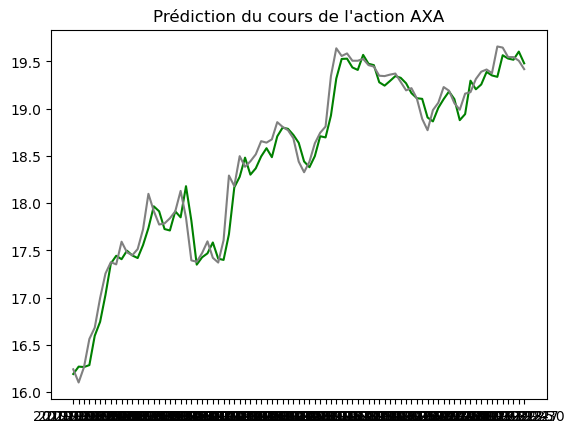

In [97]:
X = df_init[['Open', 'Close_veille']]
Y = df_init[['Close']]
X = X[1:len(X)]
Y = Y[1:len(Y)]

p = int((2/3)*len(X))
X_train = X[:p]
Y_train = Y[:p]
X_test = X[p:]
Y_test = Y[p:]

 
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
print(regr.coef_)

y_pred = regr.predict(X_test)
plt.plot(y_pred, color='green')
plt.plot(Y_test, color='gray')
plt.title("Prédiction du cours de l'action AXA")


print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(Y_test, y_pred))


Ainsi, nous voyons clairement que nous arrivons à prédire les prix de fermeture. Nous voyons aussi que les coefficients pour le prix d'ouverture est de 0.858 et pour le prix de fermeture de la veille est de 0.127. On remarque aussi que la moyenne au carré de l'erreur est de 0.03, très proche de 0. 
Enfin, le coefficient de détermination est de 0.97. 

# Modèle de Black-Sholes

In [98]:
#Calcul des log-rendements
Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
df_init= df_init.assign(Log_Rdt=Log_Rdt)
df_init.head()

,Open,Close,Volume,Close_veille,Log_Rdt
Date,,,,,
2019-01-02,13.595194,13.730999,8028529,NaN,NaN
2019-01-03,13.599575,13.617099,6583413,13.730999,-0.008330
2019-01-04,13.720780,14.044962,11675578,13.617099,0.030937
2019-01-07,14.078546,13.982167,7530045,14.044962,-0.004481
2019-01-08,14.027438,14.034739,7314687,13.982167,0.003753


In [99]:
#Rajout d'un indice temporel dans la base de données
df_init.reset_index(level=None, inplace=True)
df_init= df_init.assign(t=df_init.index)
df_init.head()

,Date,Open,Close,Volume,Close_veille,Log_Rdt,t
0,2019-01-02,13.595194,13.730999,8028529,NaN,NaN,0
1,2019-01-03,13.599575,13.617099,6583413,13.730999,-0.008330,1
2,2019-01-04,13.720780,14.044962,11675578,13.617099,0.030937,2
3,2019-01-07,14.078546,13.982167,7530045,14.044962,-0.004481,3
4,2019-01-08,14.027438,14.034739,7314687,13.982167,0.003753,4


In [8]:
#Création d'une base de données d'apprentissage et d'une base de données de test

In [100]:
df=df_init.dropna()
X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
y_BS=pd.Series(df.Close)
X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)

In [101]:
#Calcul de la moyenne des log-rendements
mu=np.mean(X_BS_train.Log_Rdt)
mu

0.0012513693671724149

In [102]:
#Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
sigma

0.12558463471750803

In [103]:
#Ecriture d'une fonction qui estime le cours de l'action AXA par la formule de Black & Scholes à horizon d jour(s)

def Estim_cours_action(d):
    
    start_Date = datetime.datetime(2019, 1, 1)
    end_Date = datetime.datetime(2019, 12, 31)

    GetAXAInfo = yahooFinance.Ticker("CS.PA")

    df_init=GetAXAInfo.history(start=start_Date,end=end_Date)
    
    #Transformation du cours de l'action de la veille en une variable
    dec=df_init["Close"].shift(1)
    df_init= df_init.assign(Close_veille=dec)
    
    #Calcul des log-rendements
    Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
    df_init= df_init.assign(Log_Rdt=Log_Rdt)
    
    #Rajout d'un indice temporel dans la base de données
    df_init.reset_index(level=0, inplace=True)
    df_init= df_init.assign(t=df_init.index)
    
    #Création d'une base de données d'apprentissage et d'une base de données de test
    df=df_init.dropna()
    X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
    y_BS=pd.Series(df.Close)
    X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)
    
    #Calcul de la moyenne des log-rendements
    mu=np.mean(X_BS_train.Log_Rdt)
    
    #Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
    sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
    
    np.random.seed(94)
    val_norm=np.random.normal(0, 1)

    Est_Close_BS=y_BS_train[min(y_BS_train.index)]*np.exp((mu-(sigma**2)/2)*(d) + sigma*val_norm*np.sqrt(d))
    return Est_Close_BS

In [104]:
#Ecriture d'une fonction qui estime le cours de l'action AXA pour plusieurs horizons temporels donnés

def Estim_cours_action_serie(y):
    indexes=y.index
    Est_Close_BS_serie=[None]*len(indexes)
    j=0
    for i in indexes:
        Est_Close_BS_serie[j]=Estim_cours_action(i)
        j+=1
    Est_Close_BS_serie=pd.Series(Est_Close_BS_serie)
    return Est_Close_BS_serie

In [105]:
Estimation=Estim_cours_action_serie(y_BS_test)
indexes_0=Estimation.index

In [ ]:
#Représentation graphique dee l'erreur de prédiction entre B&S et série réelle 

y_BS_test.index=indexes_0
Erreur=y_BS_test-Estimation
plt.plot(indexes_0, Erreur)
ay=plt.gca()
ay.axhline(y=0, color='red')

In [ ]:
mse_BS=mean_squared_error(Estimation,y_BS_test)
mse_BS

In [ ]:
#Mise en oeuvre d'un modèle SVM : on cherche à prédire Close en fonction de Open et de Close_veille

In [191]:
#Base des variables dépendantes et normalisation des données
X_train_init=pd.DataFrame(X_BS_train, columns=['Open','Close_veille'])
X_test_init=pd.DataFrame(X_BS_test, columns=['Open','Close_veille'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_init)
X_test = scaler.fit_transform(X_test_init)
column_names_train = X_train_init.columns
column_names_test = X_test_init.columns
X_train=pd.DataFrame(X_train, columns=column_names_train)
X_test=pd.DataFrame(X_test, columns=column_names_test)

In [192]:
#Vecteur de variable dépendante
y_train=y_BS_train
y_test=y_BS_test

In [193]:
#Mise en oeuvre du modèle
m1=svm.SVR()
m1.fit(X_train, y_train)

SVR()

In [23]:
#Evaluation du modèle SVM : calcul de : accuracy
accuracy = m1.score(X_test, y_test)
accuracy

0.953806196610228

In [24]:
#Evaluation du modèle SVM : calcul du MSE
y_pred=m1.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mse

0.0681112844461976

In [ ]:
#En comparant les deux modèles (sur la base du critère MSE), il ressort que le modèle SVM (pour régression) est plus performant que la formule de B&S pour estimer le cours de l'action AXA à la clôture.
#Le modèle SVM a en effet produit un MSE beaucoup plus faible.

#On note également la bonne qualité de l'ajustement par modèle SVM, avec un accuracy à plus de 95%.

In [82]:
np.random.seed(111111000)
val_n=np.random.normal(0, 1)
val_n

0.29929814397553406